In [21]:
import pandas as pd
import numpy as np
from scipy import stats
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
datasets_dir = "C:/Users/vluon/Desktop/Math and Science/Student Performance Data Analysis/Student-AP-Data-Analysis/"
dataset_name = "cleaned San Diego County Schools Dataset 2015-2017.xlsx"
vosd = pd.read_excel(datasets_dir + dataset_name, sheet_name="VOSD San Diego County")
ela = pd.read_excel(datasets_dir + dataset_name, sheet_name="ELA")
math = pd.read_excel(datasets_dir + dataset_name, sheet_name="MATH")

In [23]:
# Join MATH and ELA scores into main vosd dataset for computations later.
# Join only scores for grades 3. 

math["CDSCode"] = math["County Code"].astype(str) + math["District Code"].astype(str) + math["School Code"].astype(str).apply(lambda code: "0" + code if len(code) < 7 else code)
math.rename(columns={
    "Grade": "MATH Grade",
    "Mean Scale Score": "MATH Mean Scale Score",
    "Students with Scores": "MATH Students with Scores"    
}, inplace=True)
math_g3 = math[math["MATH Grade"] == 3]
math_joiner = math_g3[["CDSCode", "MATH Grade", "MATH Mean Scale Score", "MATH Students with Scores"]]

ela["CDSCode"] = ela["County Code"].astype(str) + ela["District Code"].astype(str) + ela["School Code"].astype(str).apply(lambda code: "0" + code if len(code) < 7 else code)
ela.rename(columns={
    "Grade": "ELA Grade",
    "Mean Scale Score": "ELA Mean Scale Score",
    "Students with Scores": "ELA Students with Scores"    
}, inplace=True)
ela_g3 = ela[ela["ELA Grade"] == 3]
ela_joiner = ela_g3[["CDSCode", "ELA Grade", "ELA Mean Scale Score", "ELA Students with Scores"]]

vosd["CDSCode"] = vosd["CDSCode"].astype(str)
vosd = pd.merge(vosd, math_joiner, how="left", on=["CDSCode"])
vosd = pd.merge(vosd, ela_joiner, how="left", on=["CDSCode"])

In [24]:
# Compute AP Pass Rate for each high school

# Parameters: ni corresponds to the number of students who scored i
def compute_ap_pass_rate(n1, n2, n3, n4, n5):
    if isinstance(n1, str) or isinstance(n2, str) or isinstance(n3, str) or isinstance(n4, str) or isinstance(n5, str):
        return None
    return (n3 + n4 + n5) / (n1 + n2 + n3 + n4 + n5)


#numeric_filter = pd.to_numeric(vosd["2015-2016 AP Score = 1"], errors='coerce').notna()
#vosd_ap_schools = vosd[numeric_filter]
#total_ap_tests = vosd_ap_schools["2015-2016 AP Score = 1"] + vosd_ap_schools["2015-2016 AP Score = 2"] + vosd_ap_schools["2015-2016 AP Score = 3"] + vosd_ap_schools["2015-2016 AP Score = 4"] + vosd_ap_schools["2015-2016 AP Score = 5"]
#(vosd["2015-2016 AP Score = 3"] + vosd["2015-2016 AP Score = 4"] + vosd["2015-2016 AP Score = 5"]) / (total_ap_tests)
vosd["AP Pass Rate"] = vosd.apply(lambda row: compute_ap_pass_rate(
    row["2015-2016 AP Score = 1"],
    row["2015-2016 AP Score = 2"],
    row["2015-2016 AP Score = 3"],
    row["2015-2016 AP Score = 4"],
    row["2015-2016 AP Score = 5"]
), axis=1)
"""vosd[[
    "School",
    "District",
    "2015-2016 AP Score = 1",
    "2015-2016 AP Score = 2",
    "2015-2016 AP Score = 3",
    "2015-2016 AP Score = 4",
    "2015-2016 AP Score = 5",
    "AP Pass Rate"
]]"""

'vosd[[\n    "School",\n    "District",\n    "2015-2016 AP Score = 1",\n    "2015-2016 AP Score = 2",\n    "2015-2016 AP Score = 3",\n    "2015-2016 AP Score = 4",\n    "2015-2016 AP Score = 5",\n    "AP Pass Rate"\n]]'

In [25]:
# Separate vosd by district type 
vosd_hsd = vosd[vosd["DOCType"] == "High School District"]
vosd_esd = vosd[vosd["DOCType"] == "Elementary School District"]
vosd_usd = vosd[(vosd["DOCType"] == "Unified School District") 
                | (vosd["DOCType"] == "County Office of Education (COE)") 
                | (vosd["DOCType"] == "State Board of Education") 
                | (vosd["DOCType"] == "Statewide Benefit Charter")]

In [26]:
# Used to assist gathering the schools that feed into High School Districts
hsd_feeders = {
    district_name: {} for district_name in vosd_hsd["District"].unique()
}
hsd_feeders["Escondido Union High"] = {"Escondido Union", "San Pasqual Union Elementary"}
hsd_feeders["Fallbrook Union High"] = {"Fallbrook Union Elementary"}
hsd_feeders["Grossmont Union High"] = {"Alpine Union Elementary", "Cajon Valley Union", "La Mesa-Spring Valley", "Lemon Grove", "Santee"}
hsd_feeders["Sweetwater Union High"] = {"Chula Vista Elementary", "National Elementary", "San Ysidro Elementary", "South Bay Union"}
hsd_feeders["San Dieguito Union High"] = {"Cardiff Elementary", "Del Mar Union Elementary", "Encinitas Union Elementary", "Rancho Santa Fe Elementary", "Solana Beach Elementary"}
hsd_feeders["Julian Union High"] = {"Julian Union Elementary"} 

hsd_feeders

{'Fallbrook Union High': {'Fallbrook Union Elementary'},
 'Grossmont Union High': {'Alpine Union Elementary',
  'Cajon Valley Union',
  'La Mesa-Spring Valley',
  'Lemon Grove',
  'Santee'},
 'Sweetwater Union High': {'Chula Vista Elementary',
  'National Elementary',
  'San Ysidro Elementary',
  'South Bay Union'},
 'San Dieguito Union High': {'Cardiff Elementary',
  'Del Mar Union Elementary',
  'Encinitas Union Elementary',
  'Rancho Santa Fe Elementary',
  'Solana Beach Elementary'},
 'Escondido Union High': {'Escondido Union', 'San Pasqual Union Elementary'},
 'Julian Union High': {'Julian Union Elementary'}}

In [27]:
def is_high_school(gsoffered: str) -> bool:
    # This set comprises all unique ranges in which a grade in 9-12 is included
    hs_grade_ranges = {"9-12","K-12","7-12","11-12","6-12"}
    return gsoffered in hs_grade_ranges

def is_ele_school(gsoffered: str) -> bool:
    return not is_high_school(gsoffered)

def is_k12(gsoffered: str) -> bool:
    return gsoffered == "K-12"

In [28]:
# Used on high schools to return what districts should be considered in assignment, given this high school's district type
def get_correct_districts(district_name:str, district_type: str) -> set:
    if district_type == "Unified School District":
        return {district_name}
    elif district_type == "High School District":
        return {district_name} | hsd_feeders[district_name]
    elif district_type == "Elementary School District":
        return {district_name}
    # Specials: {"County Office of Education (COE)", "State Board of Education", "Statewide Benefit Charter"}
    else: 
        return {district_name}

In [29]:
high_schools = vosd[vosd["GSoffered"].apply(is_high_school)]
ele_schools = vosd[vosd["GSoffered"].apply(is_ele_school)]
len(high_schools) + len(ele_schools) # for verification

695

In [30]:
# Assign each high school a set of elementary schools that feed into it
feeders = {}
for index1, hs in high_schools.iterrows():
    candidates = []

    if is_k12(hs["GSoffered"]):
        candidates.append((hs, 0))

    for index2, es in ele_schools.iterrows():
        if es["District"] not in get_correct_districts(hs["District"], hs["DOCType"]):
            continue
         
        hs_coords = (hs["Latitude"], hs["Longitude"])
        es_coords = (es["Latitude"], es["Longitude"])
        dist = distance.distance(hs_coords, es_coords).km
        candidates.append((es, dist))

    # Sort candidates based on shortest distance and take top 3
    candidates = sorted(candidates, key=lambda school_dist_pair: school_dist_pair[1])
    feeders[(hs["School"], hs["District"], hs["AP Pass Rate"])] = candidates[0:3] # would store hs row as key but can't hash that  

In [31]:
# so far tested: unified k-12 
# Other cases to test, in order of priority: high school district high school non-k12 (most difficult case), unified high school non k-12, elementary school district high school (only k-12), 

# Make sure all high schools have at least one ele feeder
print(min([len(ele_schools) for ele_schools in feeders.values()]))

# Unified K-12
#feeders[("Mt. Everest Academy", "San Diego Unified")]

1


In [32]:
# Using math to test...
ap_vs_ela_math = pd.DataFrame(columns=["High School", "AP Pass Rate", "MATH Weighted Mean Ele", "ELA Weighted Mean Ele"])
for hs, ele_feeders in feeders.items():

    # MATH
    math_weighted_avg = 0
    N_math = 0
    for ele in ele_feeders:
        n_i = ele[0]["MATH Students with Scores"]
        x_i = ele[0]["MATH Mean Scale Score"]
        if (n_i == "*") or (x_i == "*"):
            continue
        math_weighted_avg += n_i * x_i
        N_math += n_i
    if N_math == 0:
        math_weighted_avg = None
    else:
        math_weighted_avg /= N_math

    # ELA
    ela_weighted_avg = 0
    N_ela = 0
    for ele in ele_feeders:
        n_i = ele[0]["ELA Students with Scores"]
        x_i = ele[0]["ELA Mean Scale Score"]
        if (n_i == "*") or (x_i == "*"):
            continue
        ela_weighted_avg += n_i * x_i
        N_ela += n_i
    if N_ela == 0:
        ela_weighted_avg = None
    else:
        ela_weighted_avg /= N_ela

    # Construct point
    hs_id = hs[0] + "; " + hs[1]
    hs_ap_pass_rate = hs[2]
    new_row_df = pd.DataFrame([{"High School": hs_id, "AP Pass Rate": hs_ap_pass_rate, "MATH Weighted Mean Ele": math_weighted_avg, "ELA Weighted Mean Ele": ela_weighted_avg}])
    ap_vs_ela_math = pd.concat([ap_vs_ela_math, new_row_df], ignore_index=True)

C:\Users\vluon\AppData\Local\Temp\ipykernel_4564\4049801591.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ap_vs_ela_math = pd.concat([ap_vs_ela_math, new_row_df], ignore_index=True)


0.44315815534208464

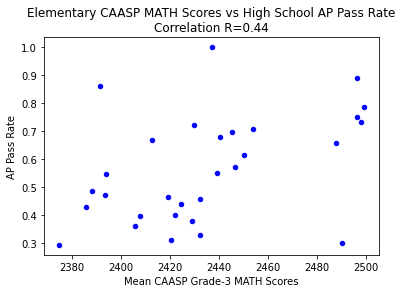

In [33]:
ap_vs_ela_math.plot(x="MATH Weighted Mean Ele", y="AP Pass Rate", kind="scatter", color="blue")
plt.xlabel("Mean CAASP Grade-3 MATH Scores")
plt.title("Elementary CAASP MATH Scores vs High School AP Pass Rate\nCorrelation R=0.44")
ap_vs_ela_math["AP Pass Rate"].corr(ap_vs_ela_math["MATH Weighted Mean Ele"])

#sns.regplot(x='MATH Weighted Mean Ele', y='AP Pass Rate', data=ap_vs_ela_math, scatter_kws={'s': 50}, ci=None, line_kws={'color': 'red'})
#plt.title('Scatter Plot with Trendline')
#plt.show()

0.47357053857484366

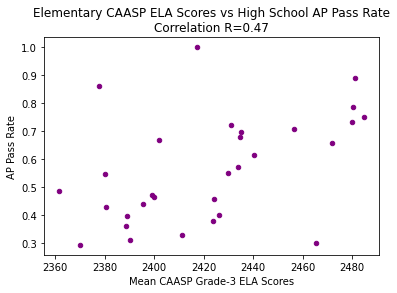

In [34]:
ap_vs_ela_math.plot(x="ELA Weighted Mean Ele", y="AP Pass Rate", kind="scatter", color="purple")
plt.xlabel("Mean CAASP Grade-3 ELA Scores")
plt.title("Elementary CAASP ELA Scores vs High School AP Pass Rate\nCorrelation R=0.47")
ap_vs_ela_math["AP Pass Rate"].corr(ap_vs_ela_math["ELA Weighted Mean Ele"])